In [14]:
import tarfile
import os
import pickle

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
import pandas as pd

import xml.etree.ElementTree as ET

from tqdm import tqdm_notebook as tqdm
import itertools




%matplotlib inline

In [15]:
def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [17]:
data_path='Data/'
img_path='images/'
annotations_path='annotations/'
train_path='train/'
test_path='test/'
val_path='validation/'

Create a dataframe to store the cooridnates of bounding box for each image

In [52]:
def data_to_df(path_images, path_annotations):
    """
    Load data annotations coordinates into a dataframe
    """
    
    df= pd.DataFrame()
    im_names=os.listdir(path_images)
    im_names=[name[:-4] for name in im_names] #get rid of the .jpg
    
    i=0
    for name in im_names:
        anno=parse_file(os.path.join(path_annotations, name) + '.xml')
        for dic in anno:
            df.loc[i,'filename']=name
            df.loc[i,'xmin']=int(dic['bbox'][0])
            df.loc[i,'ymin']=int(dic['bbox'][1])
            df.loc[i,'xmax']=int(dic['bbox'][2] + dic['bbox'][0])
            df.loc[i,'ymax']=int(dic['bbox'][3] + dic['bbox'][1])
            i+=1

    return df

In [53]:
tr_anno=data_path+annotations_path +train_path
df_train=data_to_df(data_path+img_path+train_path, tr_anno)

with open('df_train.pickle', 'wb') as df:
    pickle.dump(df_train, df, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
te_anno=data_path+annotations_path +test_path
df_test=data_to_df(data_path+img_path+test_path, te_anno)

with open('df_test.pickle', 'wb') as df:
    pickle.dump(df_test, df, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
val_anno=data_path+annotations_path +val_path
df_val=data_to_df(data_path+img_path+val_path, val_anno)

with open('df_val.pickle', 'wb') as df:
    pickle.dump(df_val, df, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
print('Nb of train images :',df_train.filename.nunique())
print('Nb of test images :',df_test.filename.nunique())
print('Nb of validation images :',df_val.filename.nunique())

Nb of train images : 532
Nb of test images : 33
Nb of validation images : 103


# Generating 40x40 images

In [38]:
def plot_rect(coor):
    plt.plot([coor[0],coor[2]],[coor[1], coor[1]], color='r')
    plt.plot([coor[0], coor[0]],[coor[1], coor[3]], color= 'r')
    plt.plot([coor[2], coor[2]], [coor[1], coor[3]], color= 'r')
    plt.plot([coor[0], coor[2]], [coor[3], coor[3]], color='r')

In [63]:
df_train.head(1)

,filename,xmin,ymin,xmax,ymax


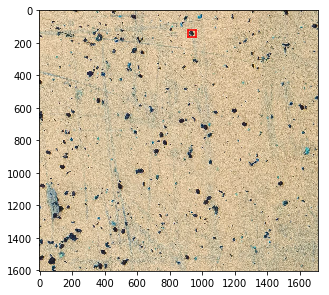

In [50]:
t=df_train.loc[0,'filename']+'.jpg'
img=cv2.imread(data_path+img_path+train_path+t)
coor=df_train.iloc[0,1:5]#.to_list()
plt.figure(figsize=(5,5))
plt.imshow(img)
plot_rect(coor)

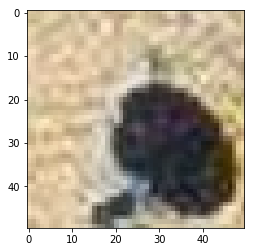

In [118]:
plt.imshow(img[coor[1]-10:coor[1]+40 , coor[0]-10:coor[0]+40])

In [4]:
def extract_varroa(img_path,df_coor, output_folder, pix=40):
    """
    Crop the image and extract the varroa location based on the 
    coordinates df
    """
    #save positive samples
    output_folder=output_folder+'1/'
    
    for i  in tqdm(range(df_coor.shape[0])):
        img=cv2.imread(img_path+df_coor.iloc[i,0]+'.jpg')
        coor=df_coor.iloc[i,1:5]
        cropped=img[int(coor[1]):int(coor[1]+pix) , int(coor[0]):int(coor[0]+pix)]
        
        cv2.imwrite(output_folder+str(i)+'.jpg',cropped)

In [5]:
def negative_sample(img_path,df_coor, output_folder, pix=40):
    """
    Extract images where there are no varroa. Records to position 
    of the array where a pixel is part of a varroa.
    Save pix*pix images empty of varroa. For each image A, as many negative 
    sub-images are generated as number of varroa per image A -->
    same number of possitive and negative examples.
    
    df_coor contains a row per box. Hence, an images containing
    several boxes would have several rows.
    """
    #save negative samples
    output_folder=output_folder+'0/'
    
    i=0
    while i < df_coor.shape[0]:
   
        im_name=df_coor.iloc[i,0]
        #get all the boudning box for each image
        df_tmp=df_coor[df_coor.filename==im_name]
        
        nbr_varroa= len(df_tmp) #all the boxes of an image
        
        #get the pixels where a varroa is present
        varroa=[]
        for ii in range(df_tmp.shape[0]):
            coor=df_coor.iloc[ii,1:5]

            x=np.arange(coor[0], coor[2])
            y=np.arange(coor[1], coor[3])

            #list of coordinates paires: [(x1,y1), (x,y), ...]
            varroa=varroa + list(itertools.product(x,y))
        
        #loading image
        img=cv2.imread(img_path+im_name+'.jpg')
        
        for j in range(nbr_varroa):
            #get random pixel coordintates in the image
            seed_x=np.random.randint(0,img.shape[1]-40)
            seed_y=np.random.randint(0,img.shape[0]-40)

            #creates the sub array of size pix*pix
            mask_x = np.arange(seed_x, seed_x+pix+1)
            mask_y = np.arange(seed_y, seed_y+pix+1)

            mask=itertools.product(x,y) #store the coor as list

            #if the selected 2D window is ovelapping a varroa
            #generate other array
            while (mask in varroa):
                seed_x=np.random.randint(0,img.shape[1]-pix)
                seed_y=np.random.randint(0,img.shape[0]-pix)

                mask_x = np.arange(seed_x, seed_x+pix+1)
                mask_y = np.arange(seed_y, seed_y+pix+1)

                mask=list(itertools.product(x,y))
            
            #cropping and saving sub-image
            cropped=img[int(seed_y):int(seed_y+pix) , int(seed_x):int(seed_x+pix)]
            cv2.imwrite(output_folder+str(i+j+1)+'.jpg',cropped)
        
        i += 1+nbr_varroa

In [6]:
data_extr='./Data_Extracted/'

#### Train

In [ ]:
with open('df_train.pickle', 'rb') as handle:
    df_train = pickle.load(handle)

In [ ]:
output_folder=data_extr+train_path
extract_varroa(data_path+img_path+train_path, df_train, output_folder)

In [180]:
output_folder=data_extr+train_path
negative_sample(data_path+img_path+train_path, df_train, output_folder)

0


#### Test

In [181]:
with open('df_test.pickle', 'rb') as handle:
    df_test = pickle.load(handle)

In [182]:
output_folder=data_extr+test_path
extract_varroa(data_path+img_path+test_path, df_test, output_folder)

In [192]:
output_folder=data_extr+test_path
negative_sample(data_path+img_path+test_path, df_test, output_folder)

#### Validation

In [18]:
with open('df_val.pickle', 'rb') as handle:
    df_val = pickle.load(handle)

In [19]:
output_folder=data_extr+val_path
extract_varroa(data_path+img_path+val_path, df_val, output_folder)

In [20]:
output_folder=data_extr+val_path
negative_sample(data_path+img_path+val_path, df_val, output_folder)

# For R-CNN potential model

In [12]:
def formating(data_dir,row):
    """
    Puts the annotations and the filename in the correct format
    for RNN training:
        filepath,x1,y1,x2,y2,class_name
    """
    anno=data_dir+row[0]+'.jpg,'+str(int(row[1]))+','+\
        str(int(row[2]))+','+str(int(row[3]))+','+str(int(row[4]))+',Varroa'
    return anno

In [13]:
train_dir=data_path+img_path+train_path
train_anno=pd.DataFrame()
train_anno['format']=df_train.apply(lambda row: formating('../'+train_dir, row), axis=1)

In [14]:
train_anno.head()

,format
0,../Data/images/train/59023fbd579e52581ddede9f_...
1,../Data/images/train/59023fbd579e52581ddede9f_...
2,../Data/images/train/59023fbd579e52581ddede9f_...
3,../Data/images/train/59023fbd579e52581ddede9f_...
4,../Data/images/train/59023fbd579e52581ddede9f_...


In [15]:
train_anno.to_csv('annotate.txt', header=None, index=None, sep=' ')